# Next Word Generation using LSTM

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, pad_sequences, to_categorical

# import train test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import random
import time

2026-01-06 20:35:14.073892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767731714.413786      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767731714.503766      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767731715.288586      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767731715.288661      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767731715.288665      17 computation_placer.cc:177] computation placer alr

# Load Data

In [ ]:
with open("./data/breaking_news.txt", "r", encoding="utf-8") as f:
    news = f.read()

print(news[:500])  # sanity check

Authorities confirmed early this morning that negotiations resumed overnight following intense diplomatic pressure from regional partners.
Markets reacted cautiously as investors weighed fresh economic data against ongoing geopolitical uncertainty across multiple regions.
Emergency services responded quickly after reports of an incident disrupted transportation routes near the city center.
Government officials stated that public safety remains the top priority as investigations continue into the


# Preprocessing & Feature Engineering

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([news])
print(type(tokenizer.word_index.items()))
print(tokenizer.word_index.items())

<class 'dict_items'>
dict_items([('the', 1), ('to', 2), ('as', 3), ('of', 4), ('officials', 5), ('a', 6), ('authorities', 7), ('that', 8), ('while', 9), ('confirmed', 10), ('following', 11), ('and', 12), ('an', 13), ('by', 14), ('reported', 15), ('would', 16), ('response', 17), ('overnight', 18), ('markets', 19), ('economic', 20), ('data', 21), ('ongoing', 22), ('uncertainty', 23), ('emergency', 24), ('services', 25), ('after', 26), ('transportation', 27), ('public', 28), ('safety', 29), ('continue', 30), ('term', 31), ('on', 32), ('information', 33), ('announced', 34), ('international', 35), ('measures', 36), ('experts', 37), ('additional', 38), ('during', 39), ('in', 40), ('resumed', 41), ('from', 42), ('reacted', 43), ('across', 44), ('responded', 45), ('reports', 46), ('incident', 47), ('government', 48), ('into', 49), ('situation', 50), ('until', 51), ('is', 52), ('issued', 53), ('financial', 54), ('regulators', 55), ('began', 56), ('amid', 57), ('closely', 58), ('travel', 59), ('

In [4]:
tokenized_sents  = []
input_token_seqs = []
for sent in news.split('\n'):
    sent_seq = tokenizer.texts_to_sequences([sent])[0]
    tokenized_sents.append(sent_seq)
    print(f'{sent} ->>>>>>> {sent_seq}')

    for i in range(1, len(sent_seq)):
        input_token_seqs.append(sent_seq[:i+1])

Authorities confirmed early this morning that negotiations resumed overnight following intense diplomatic pressure from regional partners. ->>>>>>> [7, 10, 92, 93, 94, 8, 95, 41, 18, 11, 96, 97, 98, 42, 99, 100]
Markets reacted cautiously as investors weighed fresh economic data against ongoing geopolitical uncertainty across multiple regions. ->>>>>>> [19, 43, 101, 3, 102, 103, 104, 20, 21, 105, 22, 106, 23, 44, 107, 108]
Emergency services responded quickly after reports of an incident disrupted transportation routes near the city center. ->>>>>>> [24, 25, 45, 109, 26, 46, 4, 13, 47, 110, 27, 111, 112, 1, 113, 114]
Government officials stated that public safety remains the top priority as investigations continue into the developing situation. ->>>>>>> [48, 5, 115, 8, 28, 29, 116, 1, 117, 118, 3, 119, 30, 49, 1, 120, 50]
Analysts warned that short-term volatility may persist until clearer policy guidance is issued by financial regulators. ->>>>>>> [121, 122, 8, 123, 31, 124, 125, 126,

In [5]:
input_token_seqs[:50]

[[7, 10],
 [7, 10, 92],
 [7, 10, 92, 93],
 [7, 10, 92, 93, 94],
 [7, 10, 92, 93, 94, 8],
 [7, 10, 92, 93, 94, 8, 95],
 [7, 10, 92, 93, 94, 8, 95, 41],
 [7, 10, 92, 93, 94, 8, 95, 41, 18],
 [7, 10, 92, 93, 94, 8, 95, 41, 18, 11],
 [7, 10, 92, 93, 94, 8, 95, 41, 18, 11, 96],
 [7, 10, 92, 93, 94, 8, 95, 41, 18, 11, 96, 97],
 [7, 10, 92, 93, 94, 8, 95, 41, 18, 11, 96, 97, 98],
 [7, 10, 92, 93, 94, 8, 95, 41, 18, 11, 96, 97, 98, 42],
 [7, 10, 92, 93, 94, 8, 95, 41, 18, 11, 96, 97, 98, 42, 99],
 [7, 10, 92, 93, 94, 8, 95, 41, 18, 11, 96, 97, 98, 42, 99, 100],
 [19, 43],
 [19, 43, 101],
 [19, 43, 101, 3],
 [19, 43, 101, 3, 102],
 [19, 43, 101, 3, 102, 103],
 [19, 43, 101, 3, 102, 103, 104],
 [19, 43, 101, 3, 102, 103, 104, 20],
 [19, 43, 101, 3, 102, 103, 104, 20, 21],
 [19, 43, 101, 3, 102, 103, 104, 20, 21, 105],
 [19, 43, 101, 3, 102, 103, 104, 20, 21, 105, 22],
 [19, 43, 101, 3, 102, 103, 104, 20, 21, 105, 22, 106],
 [19, 43, 101, 3, 102, 103, 104, 20, 21, 105, 22, 106, 23],
 [19, 43, 101

In [6]:
max_pad_len = max([len(x) for x in input_token_seqs])
max_pad_len

18

In [7]:
padded_input_seqs = pad_sequences(input_token_seqs, maxlen=max_pad_len, padding='pre')

In [8]:
X = padded_input_seqs[:, :-1]
y = padded_input_seqs[:, -1]

In [9]:
X.shape, y.shape

((593, 17), (593,))

In [10]:
no_of_tokens = len(tokenizer.word_index) + 1
y = to_categorical(y, num_classes=no_of_tokens)
y.shape

(593, 436)

# Model Building

In [11]:
model = Sequential()
model.add(Input(shape=(max_pad_len, )))
model.add(Embedding(no_of_tokens, 100))
model.add(LSTM(150))
model.add(Dense(no_of_tokens, activation='softmax'))

2026-01-06 20:35:37.648014: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 18, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 436)            │        65,836 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,036 (1015.77 KB)

 Trainable params: 260,036 (1015.77 KB)

 Non-trainable params: 0 (0.00 B)

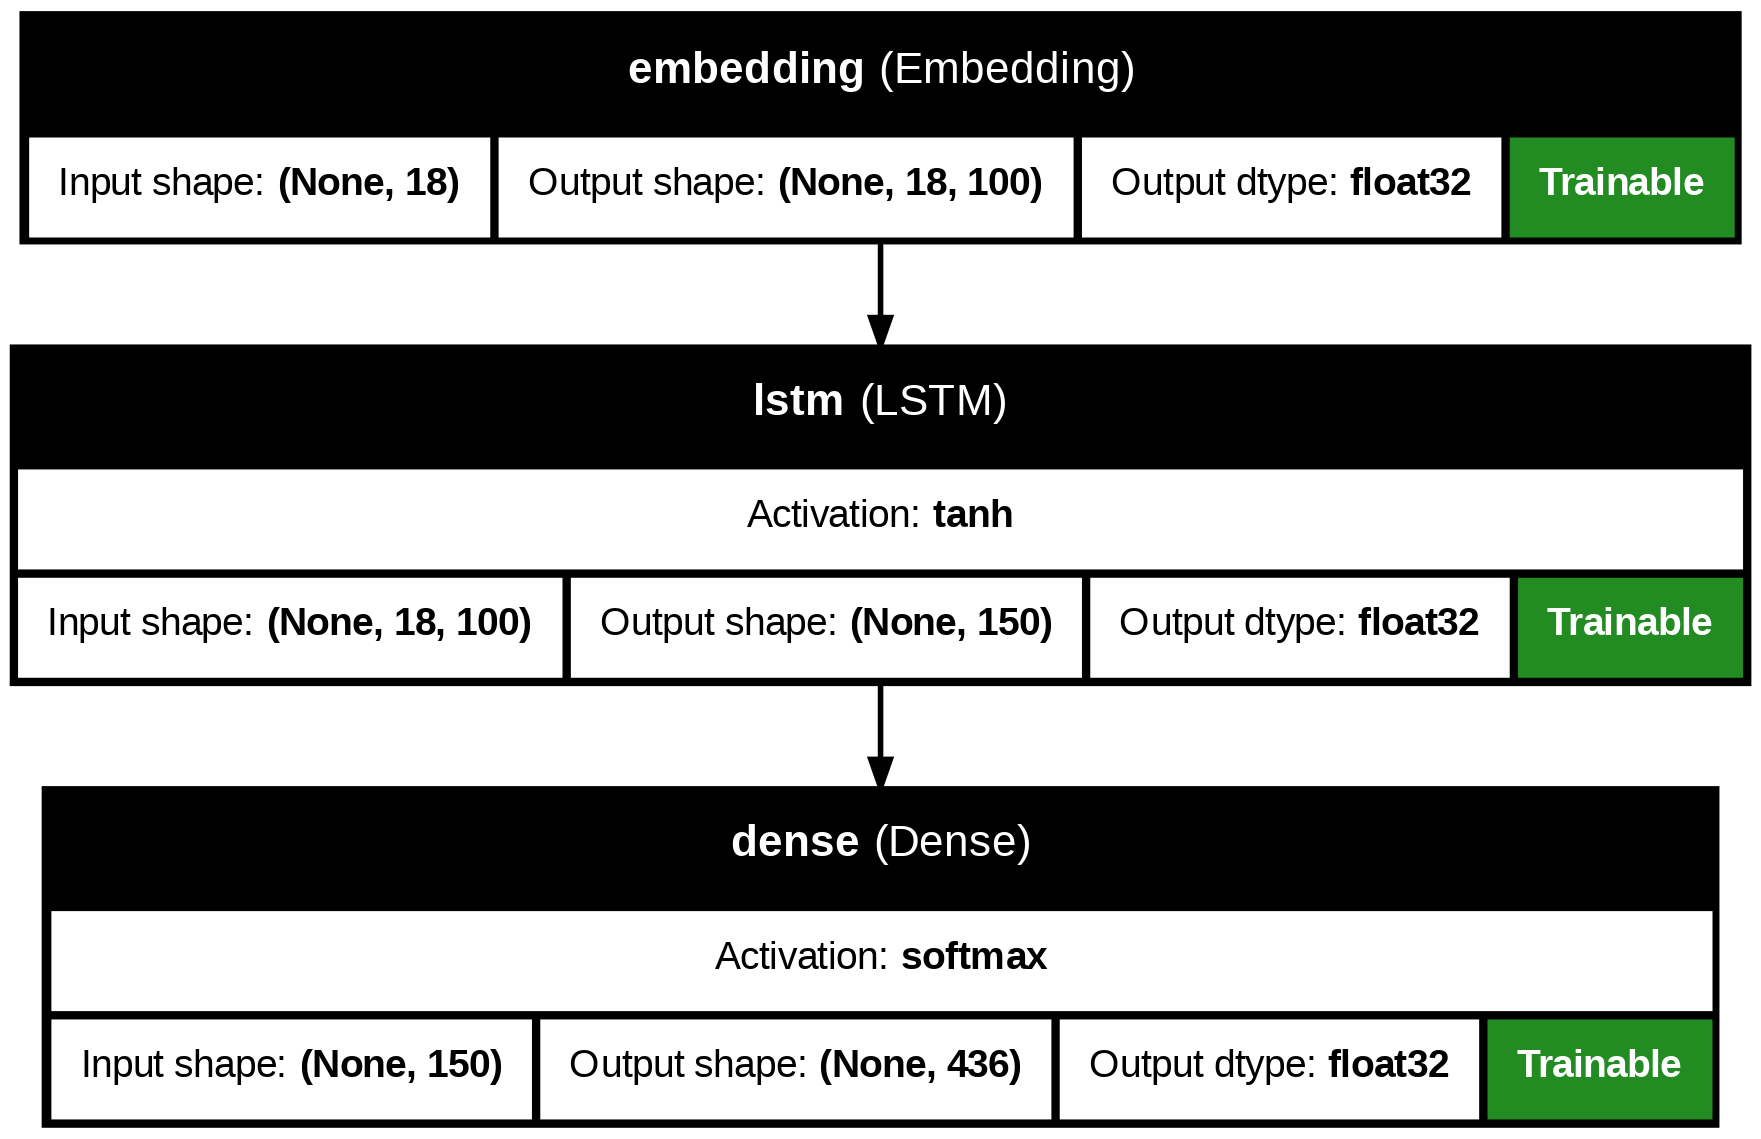

In [13]:
plot_model(
    model, 
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    show_layer_names=True,
    show_trainable=True
)

In [14]:
es = EarlyStopping(monitor="accuracy", patience=5, restore_best_weights=True, verbose=1)

In [15]:
history = model.fit(
    X, 
    y,
    batch_size=5,
    epochs=100,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0072 - loss: 6.0804 - val_accuracy: 0.0084 - val_loss: 6.0821
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0112 - loss: 6.0120 - val_accuracy: 0.0252 - val_loss: 6.5042
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0194 - loss: 5.6903 - val_accuracy: 0.0420 - val_loss: 6.6361
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0363 - loss: 5.4847 - val_accuracy: 0.0336 - val_loss: 6.9537
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0574 - loss: 5.2344 - val_accuracy: 0.0420 - val_loss: 7.6200
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0511 - loss: 4.8420 - val_accuracy: 0.0168 - val_loss: 7.5850
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0971 - loss: 4.5040 - val_accuracy: 0.0420 - val_loss: 8.0192
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1085 - loss: 4.0866 - val_accuracy: 0.

# Text Generation

In [16]:
def get_key_from_value(d, val):
    for key, value in d.items():
        if value == val:
            return key

In [17]:
index = random.randint(1, len(tokenizer.word_index.items()))
max_tokens = random.randint(10, 15)
text = get_key_from_value(tokenizer.word_index, index)

for i in range(1, max_tokens):
    # tokenize
    txt_token = tokenizer.texts_to_sequences([text])[0]
    # padding
    padded_token = pad_sequences([txt_token], maxlen=max_pad_len, padding='pre')
    # predict
    output_idx = np.argmax(model.predict(padded_token))
    text = f'{text} {get_key_from_value(tokenizer.word_index, output_idx)}'
    time.sleep(1)
    print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
geopolitical experts
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
geopolitical experts noted
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
geopolitical experts noted that
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
geopolitical experts noted that upcoming
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
geopolitical experts noted that upcoming court
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
geopolitical experts noted that upcoming court proceedings
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
geopolitical experts noted that upcoming court proceedings could
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
geopolitical experts noted that upcoming court proceedings could set
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
geopolitical experts noted that upcoming court proceedings could set an
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
geopolitical experts noted that upcoming court proceedings could set an important
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
geopolitical experts noted that upcoming court proceedings could s